# MACD and BB

In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import talib
import quantstats
plt.style.use('ggplot')

## 資料整理 

In [13]:
df = pd.read_csv('台指近月期貨指數.csv')
df = df.rename(columns={'日期':"datetime"})
df.index = pd.to_datetime(df['datetime'])
df.sort_index(inplace=True)
df = df.drop(columns=['datetime', '期貨名稱', '簡稱', '報酬率', '未平倉合約數', '基差', '未沖銷契約數(合計)'])
df.columns=['Open', 'High', 'Low', 'Close', 'Volume']

### 觀察資料

In [14]:
# plt.figure(figsize=(15,7))

# plt.subplot(2,1,1)
# plt.plot(df['Close'], color = 'red', alpha = 0.5, label = 'Close price')
# plt.legend(loc='upper left')
# plt.title('Close price')

# plt.subplot(2,1,2)
# plt.fill_between(df.index, df['Volume'], 0, color = '#01889f', alpha = 0.5, label='Volume')
# plt.legend(loc='upper left')
# plt.title('Volume')

### 選擇回測資料

In [15]:
# trainData = df[(df.index >= '2010-01-01') & (df.index <= '2019-12-31')].copy()  # 樣本內
# trainData = df[(df.index >= '2020-01-01') & (df.index <= '2023-06-30')].copy()  # 樣本外
trainData = df[(df.index >= '2010-01-01') & (df.index <= '2023-06-30')].copy()  # 全樣本

### 取得結算日資料

In [16]:
settlementDate = pd.read_csv('settlementDate.csv')
settlementDate.columns = ['settlementDate', 'futures', 'settlementPrice']
bool = []
for i in settlementDate['futures']:
    if 'W' in i:
        bool.append(False)
    else:
        bool.append(True)
# print(len(list(settlementDate[bool]['futures'])))
# print(12*25 + 4 + 7) # 1999~2023 共 25 年＊12個月，再加上 1998 年的9,10,11,12月期貨和今年的 1,2,3,4,5,6,7月期貨
settlementDate = [i.replace('/','-') for i in list(settlementDate[bool]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

## 回測
* 換月轉倉：結算日當天直接平倉
* 進場限制：結算日當天不進場
* 報酬計算：200 * 點數
* 手續費+滑價：單邊 600元

In [17]:
# 參數設定
fund = 1000000
feePaid = 600
fastperiod = 10
slowperiod = 20
signalperiod = 10
timeperiod = 10
nbdevup = 3
nbdevdn = 2.5

# 技術指標
macd, macdsignal, macdhist = talib.MACD(trainData["Close"], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
trainData['macd'] = macd  # 5
trainData['macdsignal'] = macdsignal 
trainData["macdhist"] = macdhist  # MACD線 - 訊號線

upperband, middleband, lowerband = talib.BBANDS(trainData["Close"], timeperiod=timeperiod, nbdevup=nbdevup, nbdevdn=nbdevdn, matype=0)
trainData["upperband"] = upperband  # 8
trainData["lowerband"] = lowerband

trainData.tail(3)

,Open,High,Low,Close,Volume,macd,macdsignal,macdhist,upperband,lowerband
datetime,,,,,,,,,,
2023-06-28,16795.0,16810.0,16712.0,16776.0,75639,123.491010,209.148218,-85.657208,17737.720161,16586.899866
2023-06-29,16851.0,16965.0,16733.0,16756.0,111710,93.612917,188.141799,-94.528882,17753.926271,16488.328108
2023-06-30,16718.0,16826.0,16671.0,16788.0,76943,72.644928,167.142368,-94.497441,17737.586415,16425.861321


In [18]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]  # 提取日期部分

### 做多

In [19]:
# 建立存放資料的單位
BS = None  # 交易狀態
buy = []   # 買入時間點
sell = []  # 賣出時間點
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

# 開始交易流程
for i in range(len(df_arr)):

    # 回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    # 進場邏輯
    entryLong = (df_arr[i,7] > 0) and (df_arr[i,3] < df_arr[i, 8])  # 收盤價 < 上軌 
    entryCondition = date_arr[i] not in settlementDate

    # 出場邏輯
    exitShort = (df_arr[i,7] < 0) and (df_arr[i,3] > df_arr[i, 9])   # 收盤價 > 下軌
    exitCondition = date_arr[i] in settlementDate  # 結算日平倉

    # 做多的狀態
    # if BS == 'B':
    #     # 停利停損條件
    #     stopLoss = df_arr[i,3] <= df_arr[t,0] * 0.94
    #     stopProfit = df_arr[i,3] >= df_arr[t,0] * 1.06

    # 還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        # 確認進場&相關設定
        if entryLong and entryCondition:
            # 更改狀態至作多
            BS = 'B'
            # 紀錄進場時間
            t = i+1
            buy.append(t)
            # print('Buy Price: {}, time: {}'.format(df_arr[t,0], time_arr[t]))
    
    # 進場才開始計算未實現損益 
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
         # 出場條件達成，計算未實現損益-交易成本
        if exitShort or i == len(df_arr)-2 or exitCondition:  # -2是因為出場條件達成後隔天才出場，所以其實是最後一天出場的意思
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])  # 部位從買到賣賺的價差
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            
            # 紀錄出場時間
            sell.append(i+1)

            # 重置交易狀態
            BS = None
            # print('Sell Price: {}, time: {}'.format(df_arr[i+1,0], time_arr[i+1]))
            # print('Trade completed')
            # print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))
         
        # 出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# equity.plot(grid=True, figsize=(12,6))

#### 績效

In [20]:
## 基本指標
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1  # 現在相對於過去最高點跌多少?
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() 
profit = equity['profitfee'].iloc[-1]  # 總利潤
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
tradeTimes = len(buy) + len(sell)  
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))
# 年化報酬 (單利)
annual_equity = equity['equity'].resample('YE').agg(['first', 'last'])
annual_equity['Return'] = (annual_equity['last'] / annual_equity['first']) - 1
start_date = equity.index.min()
end_date = equity.index.max()
yearnumber = end_date.year - start_date.year + (end_date.month - start_date.month + 1) / 12  
annualret=annual_equity['Return'].sum()/yearnumber
# 日報酬%
daily_return = equity['equity'].pct_change()
# 年化波動度%
annualVolatility = daily_return.std()*(252**0.5)

# print('累積報酬 : {}%'.format(round(ret*100,2)))
# print('年化報酬 : {}%'.format(round(annualret*100,2)))  
# print('年化波動度 : {}%'.format(round(annualVolatility*100,2))) 
# print('MDD : {}%'.format(round(mdd*100,2)))
# print('年化夏普 :',round(annualret/annualVolatility,2))  # 年化報酬 / 年化波動度
# print('風報比 :',round(ret/mdd,2))  
# print('交易次數 :',tradeTimes)
# print('獲利因子 :',round(profitFactor,2))
# print('勝率 : {}%'.format(round(winRate*100,2)))

result = pd.DataFrame({
    "績效指標":['累積報酬', '年化報酬', '年化波動度', 'MDD', '年化夏普', '風報比', '交易次數', '獲利因子', '勝率'],
    "value": [
        f"{round(ret*100, 2)}%",  # 累積報酬
        f"{round(annualret*100, 2)}%",  # 年化報酬
        f"{round(annualVolatility*100, 2)}%",  # 年化波動度
        f"{round(mdd*100, 2)}%",  # MDD
        round(annualret/annualVolatility, 2),  # 年化夏普
        round(ret/mdd, 2),  # 風報比
        tradeTimes,  # 交易次數
        round(profitFactor, 2),  # 獲利因子
        f"{round(winRate*100, 2)}%"  # 勝率
    ]}, index=range(1,10))
result

,績效指標,value
1,累積報酬,202.56%
2,年化報酬,9.78%
3,年化波動度,13.91%
4,MDD,26.8%
5,年化夏普,0.7
6,風報比,7.56
7,交易次數,394
8,獲利因子,1.74
9,勝率,47.72%


In [21]:
## quantstats回測報表
# ret = equity['equity'].pct_change(periods=1).dropna()
# quantstats.reports.full(ret)
# quantstats.reports.html(ret,output='stats.html',title='backtest result',download_filename='result.html')
quantstats.__file__

'c:\\Users\\陳默然\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\quantstats\\__init__.py'

Text(0.5, 1.0, 'Return by year')

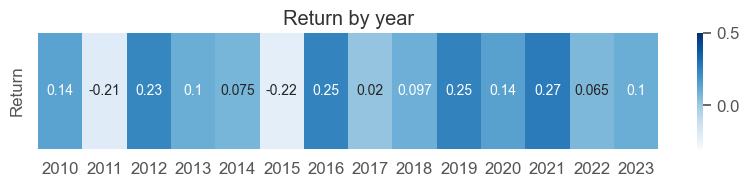

In [22]:
## 時間損益(年)
equity.index = pd.to_datetime(equity.index)  # 確保索引是datetime型態
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
year_ret = []
# print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_ret.append(equity[equity.index.year == i]['equity'].iloc[-1]/equity[equity.index.year == i]['equity'].iloc[0] - 1)
df1 = pd.DataFrame({'Return':year_ret}, index = years)

# heatmap
plt.figure(figsize=(10,1.5))
sns.heatmap(df1.transpose(), annot=True, cmap='Blues', vmin=-0.3, vmax=0.5)
plt.title('Return by year')

Text(0.5, 1.0, 'MDD by year')

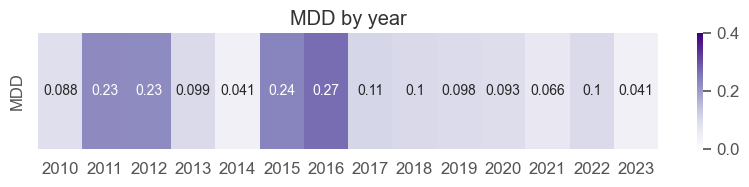

In [23]:
## 時間MDD(年)
equity.index = pd.to_datetime(equity.index)  # 確保索引是datetime型態
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
year_MDD = []
# print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_MDD.append(abs(equity[equity.index.year == i]['drawdown_percent'].min()))
df1 = pd.DataFrame({'MDD':year_MDD}, index = years)

# heatmap
plt.figure(figsize=(10,1.5))
sns.heatmap(df1.transpose(), annot=True, cmap='Purples', vmin=0, vmax=0.4)
plt.title('MDD by year')

In [24]:
## 時間損益(月)
# group_data = equity.groupby([equity.index.year, equity.index.month])
# month_ret = []
# for group, data in group_data:
#     month_ret.append(data['equity'].iloc[-1]/data['equity'].iloc[0] - 1)
# month_ret_padded = np.append(month_ret, [np.nan] * (20*12 - len(month_ret)))
# df1 = pd.DataFrame(np.array(month_ret_padded).reshape((20,12)), columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], index = years)

# # heatmap
# plt.figure(figsize=(15,15))
# sns.heatmap(df2, annot=True, cmap='OrRd')
# plt.title('Return by month')

In [25]:
## 損益分布
# print(rets)
# sns.histplot(rets, kde=True)
# plt.xlabel('Return per trade')
# plt.ylabel('Frequency')
# plt.title('Profit Loss Distribution')

Text(0.5, 1.0, 'Strategy VS. Buy&hold')

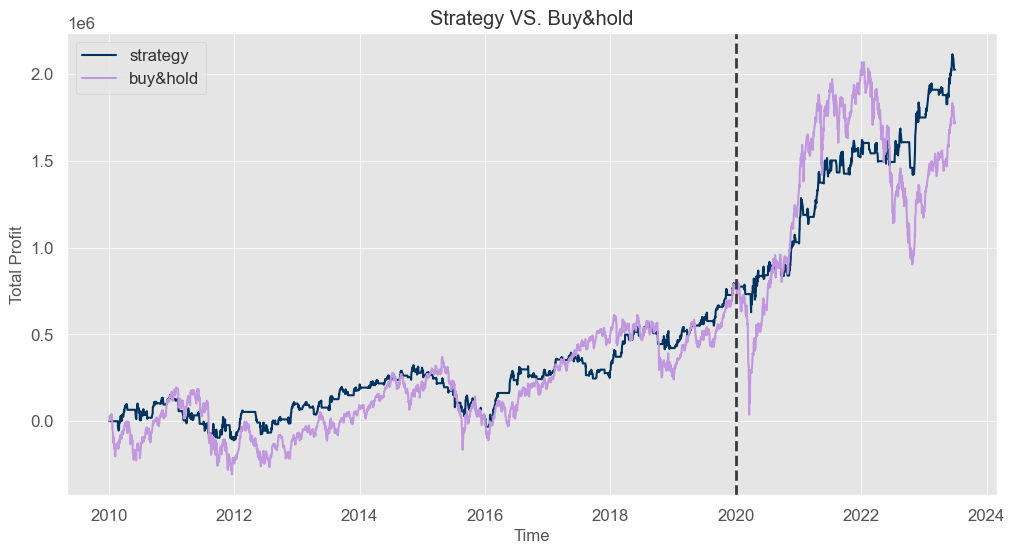

In [26]:
# 比較單獨持有與執行策略的損益
trainData['ret']=trainData['Close'].diff()*200
trainData['cum_ret']=trainData['ret'].cumsum()
plt.figure(figsize=(12,6))
plt.plot(equity['profitfee'], label="strategy", c="#013360")
plt.plot(trainData['cum_ret'], label='buy&hold', c="#c198e0")
plt.axvline(x=pd.Timestamp('2020-01-01'), color='#343a40', linestyle='--', linewidth=2)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Total Profit')
plt.title('Strategy VS. Buy&hold')

Text(0.5, 1.0, 'Profit & Drawdown')

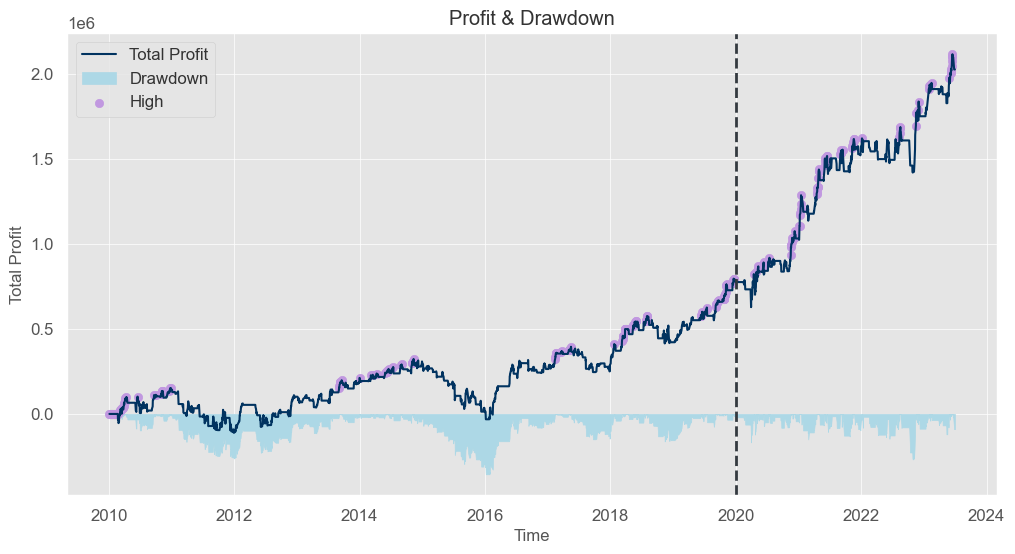

In [27]:
## Profit & Drawdown 
MDD_series = equity['profitfee'].cummax() - equity['profitfee']
high_index = equity['profitfee'][equity['profitfee'].cummax() == equity['profitfee']].index
plt.figure(figsize=(12,6))
plt.plot(equity['profitfee'],label="Total Profit" ,c="#013360")
plt.fill_between(MDD_series.index, -MDD_series, 0, label='Drawdown', color='lightblue')
plt.scatter(high_index, equity['profitfee'].loc[high_index], c='#c198e0', label='High')
plt.axvline(x=pd.Timestamp('2020-01-01'), color='#343a40', linestyle='--', linewidth=2)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Total Profit')
plt.title('Profit & Drawdown')

#### 參數最佳化

In [28]:
## 要確認為樣本內資料
# optimizationList = []
# fund = 1000000
# feePaid = 600
# fastperiod = 10
# slowperiod = 20
# signalperiod = 10
# timeperiod = 10
# nbdevup = 3
# nbdevdn = 2.5

# for fastperiod in range(10, 40, 10):
#     for slowperiod in range(20, 50, 10):
#         for signalperiod in range(5, 20, 5):
#              for timeperiod in range(5, 20, 5):
#                 for nbdevup in np.arange(1.5, 4, 0.5):
#                     for nbdevdn in np.arange(1.5, 4, 0.5):

#                         nbdevup = np.round(nbdevup, 1)
#                         nbdevdn = np.round(nbdevdn, 1)
#                         print('----------')
#                         print(f'fastperiod: {fastperiod}')
#                         print(f'slowperiod: {slowperiod}')
#                         print(f'signalperiod: {signalperiod}')
#                         print(f'timeperiod: {timeperiod}')
#                         print(f'nbdevup: {nbdevup}')
#                         print(f'nbdevdn: {nbdevdn}')

#                         # 技術指標
#                         macd, macdsignal, macdhist = talib.MACD(trainData["Close"], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
#                         trainData['macd'] = macd
#                         trainData['macdsignal'] = macdsignal
#                         trainData["macdhist"] = macdhist  # MACD 線和訊號線之間的差值

#                         upperband, middleband, lowerband = talib.BBANDS(trainData["Close"], timeperiod=timeperiod, nbdevup=nbdevup, nbdevdn=nbdevdn, matype=0)
#                         trainData["upperband"] = upperband
#                         trainData["lowerband"] = lowerband

#                         df_arr = np.array(trainData)
#                         time_arr = np.array(trainData.index)
#                         date_arr = [pd.to_datetime(i).date() for i in time_arr]  # 提取日期部分

#                         ## 做多
#                         # 建立存放資料的單位
#                         BS = None  # 交易狀態
#                         buy = []   # 買入時間點
#                         sell = []  # 賣出時間點
#                         profit_list = [0]
#                         profit_fee_list = [0]
#                         profit_fee_list_realized = []
#                         rets = []

#                         # 開始交易流程
#                         for i in range(len(df_arr)):

#                             # 回測期間最後一天就跳出這個迴圈
#                             if i == len(df_arr)-1:
#                                 break

#                             # 進場邏輯
#                             entryLong = (df_arr[i,7] > 0) and (df_arr[i,3] < df_arr[i, 8])  # 收盤價 < 上軌 (若大於上軌不進場:可能會跌)
#                             entryCondition = date_arr[i] not in settlementDate

#                             # 出場邏輯
#                             exitShort = (df_arr[i,7] < 0) and (df_arr[i,3] > df_arr[i, 9])  # 收盤價 > 下軌 (若小於下軌不出場:可能會漲)
#                             exitCondition = date_arr[i] in settlementDate  # 結算日平倉
#                             # 做多的狀態
#                             # if BS == 'B':
#                             #     # 停利停損條件
#                             #     stopLoss = 
#                             #     stopProfit =

#                             # 還沒進場不用計算損益
#                             if BS == None:
#                                 profit_list.append(0)
#                                 profit_fee_list.append(0)

#                                 # 確認進場&相關設定
#                                 if entryLong and entryCondition:
#                                     # 更改狀態至作多
#                                     BS = 'B'
#                                     # 紀錄進場時間
#                                     t = i+1
#                                     buy.append(t)
#                                     # print('Buy Price: {}, time: {}'.format(df_arr[t,0], time_arr[t]))
                            
#                             # 進場才開始計算未實現損益 
#                             elif BS == 'B':
#                                 profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
#                                 profit_list.append(profit)
#                                 # 出場條件達成，計算未實現損益-交易成本
#                                 if exitShort or i == len(df_arr)-2 or exitCondition:
#                                     pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])  # 部位從買到賣賺的價差
#                                     profit_fee = profit - feePaid*2
#                                     profit_fee_list.append(profit_fee)
                                    
#                                     # 紀錄出場時間
#                                     sell.append(i+1)

#                                     # 重置交易狀態
#                                     BS = None
#                                     # print('Sell Price: {}, time: {}'.format(df_arr[i+1,0], time_arr[i+1]))
#                                     # print('Trade completed')
#                                     # print()

#                                     # Realized PnL
#                                     profit_fee_realized = pl_round - feePaid*2
#                                     profit_fee_list_realized.append(profit_fee_realized)
#                                     rets.append(profit_fee_realized/(200*df_arr[t,0]))
                                
#                                 # 出場條件未達成，計算未實現損益
#                                 else:
#                                     profit_fee = profit
#                                     profit_fee_list.append(profit_fee)
                            
#                         equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
#                         equity['equity'] = equity['profitfee'] + fund
#                         equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
#                         equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
#                         ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
#                         mdd = abs(equity['drawdown_percent'].min())
                        
#                         optimizationList.append([fastperiod, slowperiod, signalperiod, timeperiod, nbdevup, nbdevdn, ret, ret/mdd])

# optResult = pd.DataFrame(optimizationList, columns=['fastperiod', 'slowperiod', 'signalperiod', 'timeperiod', 'nbdevup', 'nbdevdn', 'ret', '風報比'])
# optResult.to_csv("optResult1.csv", index=False)
# optResult.sort_values('ret', ascending=False).iloc[:5]  # 印出報酬前5

In [29]:
### 立體圖
# import plotly
# import plotly.express as px
# import plotly.offline as pyo
# import plotly.graph_objects as go
# import plotly.io as io

# x = np.arange(10, 110, 10)
# y = np.arange(10, 110, 10)
# x1, y1 = np.meshgrid(x, y)
# z = np.zeros((10, 10))

# for x in range(0, 10):
#     for y in range(0, 10):
#         filter1 = (optResult['fastperiod']==x1[x,y])
#         filter2 = (optResult['slowperiod']==y1[x,y])
#         #print(vol_quote[filter1][filter2]['Value'].values[0])
#         z[x,y] = optResult.loc[filter1][filter2]['ret'].values.iloc[0]

# fig = go.Figure(data=[go.Surface(x=x1, y=y1, z=z)])
# fig.update_layout(title='Surface', autosize=False, width=500, height=500,margin=dict(l=50, r=50, b=50, t=50))
# # plotly.offline.plot(fig, filename='ret.html')
# fig.show()

### 做多加碼

In [30]:
# 建立存放資料的單位
BS = None  # 交易狀態
buy = []   # 買入時間點
sell = []  # 賣出時間點
add = []  # 加碼時間點
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

Position = 0
buy_price = 0
add_price = 0
cost_list = []

for i in range(len(df_arr)):

    # 回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    # 進場邏輯
    entryLong = (df_arr[i,7] > 0) and (df_arr[i,3] < df_arr[i, 8])  # 收盤價 < 上軌 (若大於上軌不進場:可能會跌)
    entryCondition = date_arr[i] not in settlementDate

    # 出場邏輯
    exitShort = (df_arr[i,7] < 0) and (df_arr[i,3] > df_arr[i, 9])  # 收盤價 > 下軌 (若小於下軌不出場:可能會漲)
    exitCondition = date_arr[i] in settlementDate  # 結算日平倉

    # 做多的狀態
    if BS == 'B':
        # 停利停損條件
        # stopLoss = df_arr[i,3] <= df_arr[t,0] * 0.94
        # stopProfit = df_arr[i,3] >= df_arr[t,0] * 1.06

        # 做多狀態的加碼條件
        add_condition = df_arr[i,0] > buy_price

    # 還沒進場不用計算損益
    if (BS == None) and (Position == 0):
        profit_list.append(0)
        profit_fee_list.append(0)

        # 確認進場&相關設定
        if entryLong and entryCondition:
            BS = 'B'
            Position = 1
            t = i+1
            buy_price = df_arr[i+1, 0]
            # 將第一次進場成本紀錄在這個 list 中
            cost_list.append(buy_price)
            buy.append(t)
    
    # 進場才開始計算未實現損益 
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
        profit_list.append(profit)
        # 出場條件達成，計算未實現損益-交易成本
        if exitShort or i == len(df_arr)-2 or exitCondition:
            if Position > 1:
                pl_round = 200 * ((Position*df_arr[i+1,0]) - np.sum(cost_list[-2:]))  # 部位從買到賣賺的價差
            else:
                pl_round = 200 * ((Position*df_arr[i+1,0]) - cost_list[-1])
            profit_fee = profit - feePaid*2*Position  # 一口來回1200 兩口2400
            profit_fee_list.append(profit_fee)
            # 紀錄出場時間
            sell.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))
            # 重置交易狀態
            BS = None
            # 重置部位數量
            Position = 0
            # 重置加碼參考價
            buy_price = 0
            # 重置加碼成本
            add_price = 0

        # 確認部位上限 & 加碼條件成立
        elif (Position <=1) & add_condition:
            add_price = df_arr[i+1, 0]
            # 更改部位數量
            Position += 1
            # 將第一次進場成本紀錄在這個 list 中
            cost_list.append(add_price)

            profit_fee = profit
            profit_fee_list.append(profit_fee)
            add.append(i+1)
            # print("time: {}, Buy price: {} < Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
            # print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
            # print()

        # 出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# equity.plot(grid=True, figsize=(12,6))

In [31]:
### 績效呈現

## 基本指標
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1  # 現在相對於過去最高點跌多少?
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() 
profit = equity['profitfee'].iloc[-1]  # 總利潤
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
tradeTimes = len(buy) + len(sell) + len(add)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))
# 年化報酬 (單利)
annual_equity = equity['equity'].resample('YE').agg(['first', 'last'])
annual_equity['Return'] = (annual_equity['last'] / annual_equity['first']) - 1
start_date = equity.index.min()
end_date = equity.index.max()
yearnumber = end_date.year - start_date.year + (end_date.month - start_date.month + 1) / 12  
annualret=annual_equity['Return'].sum()/yearnumber
# 日報酬%
daily_return = equity['equity'].pct_change()
# 年化波動度%
annualVolatility = daily_return.std()*(252**0.5)

result = pd.DataFrame({
    "績效指標":['累積報酬', '年化報酬', '年化波動度', 'MDD', '年化夏普', '風報比', '交易次數', '獲利因子', '勝率'],
    "value": [
        f"{round(ret*100, 2)}%",  # 累積報酬
        f"{round(annualret*100, 2)}%",  # 年化報酬
        f"{round(annualVolatility*100, 2)}%",  # 年化波動度
        f"{round(mdd*100, 2)}%",  # MDD
        round(annualret/annualVolatility, 2),  # 年化夏普
        round(ret/mdd, 2),  # 風報比
        tradeTimes,  # 交易次數
        round(profitFactor, 2),  # 獲利因子
        f"{round(winRate*100, 2)}%"  # 勝率
    ]}, index=range(1,10))
result

,績效指標,value
1,累積報酬,347.06%
2,年化報酬,14.93%
3,年化波動度,21.15%
4,MDD,39.69%
5,年化夏普,0.71
6,風報比,8.74
7,交易次數,525
8,獲利因子,1.83
9,勝率,41.12%


Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023],
      dtype='int32', name='datetime')


Text(0.5, 1.0, 'Return by year')

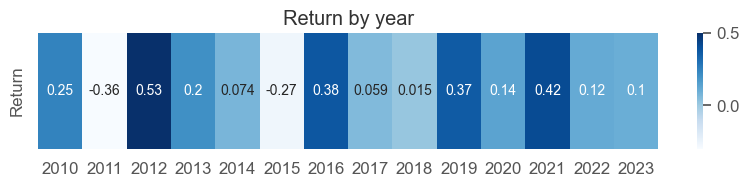

In [32]:
## 時間損益(年)
equity.index = pd.to_datetime(equity.index)  # 確保索引是datetime型態
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
year_ret = []
print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_ret.append(equity[equity.index.year == i]['equity'].iloc[-1]/equity[equity.index.year == i]['equity'].iloc[0] - 1)
df1 = pd.DataFrame({'Return':year_ret}, index = years)

# heatmap
plt.figure(figsize=(10,1.5))
sns.heatmap(df1.transpose(), annot=True, cmap='Blues', vmin=-0.3, vmax=0.5)
plt.title('Return by year')

Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023],
      dtype='int32', name='datetime')


Text(0.5, 1.0, 'MDD by year')

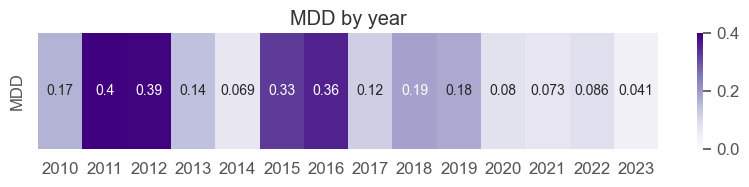

In [33]:
## 時間MDD(年)
equity.index = pd.to_datetime(equity.index)  # 確保索引是datetime型態
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
year_MDD = []
print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_MDD.append(abs(equity[equity.index.year == i]['drawdown_percent'].min()))
df1 = pd.DataFrame({'MDD':year_MDD}, index = years)

# heatmap
plt.figure(figsize=(10,1.5))
sns.heatmap(df1.transpose(), annot=True, cmap='Purples', vmin=0, vmax=0.4)
plt.title('MDD by year')

Text(0.5, 1.0, 'Strategy VS. Buy&hold')

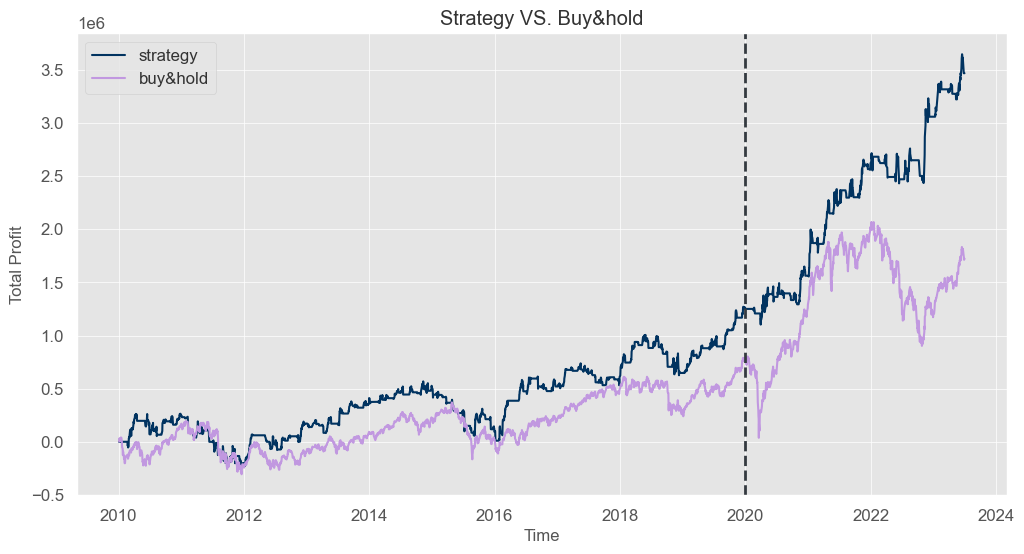

In [34]:
## 比較單獨持有與執行策略的損益
trainData['ret']=trainData['Close'].diff()*200
trainData['cum_ret']=trainData['ret'].cumsum()
plt.figure(figsize=(12,6))
plt.plot(equity['profitfee'], label="strategy", c="#013360")
plt.plot(trainData['cum_ret'], label='buy&hold', c="#c198e0")
plt.axvline(x=pd.Timestamp('2020-01-01'), color='#343a40', linestyle='--', linewidth=2)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Total Profit')
plt.title('Strategy VS. Buy&hold')

Text(0.5, 1.0, 'Profit & Drawdown')

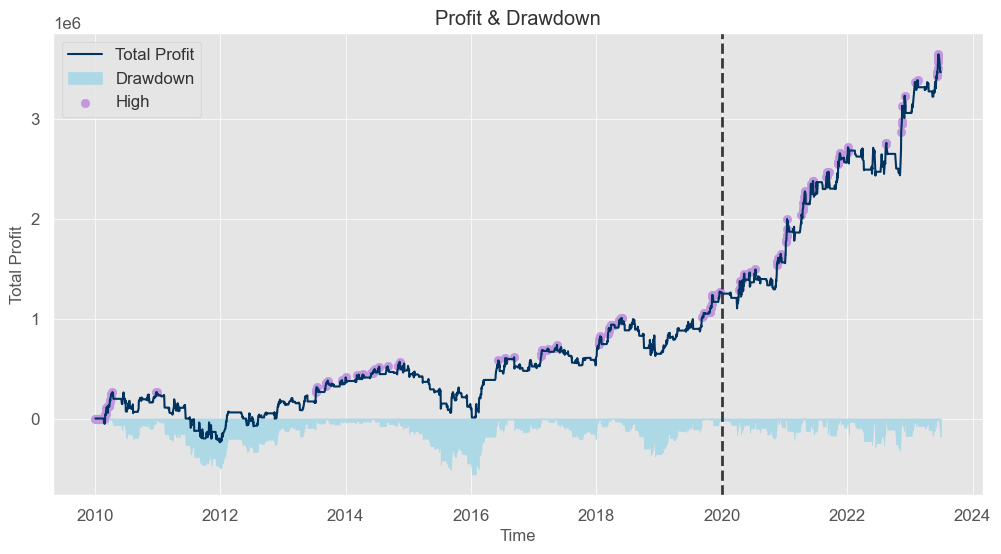

In [35]:
## Profit & Drawdown 
MDD_series = equity['profitfee'].cummax() - equity['profitfee']
high_index = equity['profitfee'][equity['profitfee'].cummax() == equity['profitfee']].index
plt.figure(figsize=(12,6))
plt.plot(equity['profitfee'],label="Total Profit" ,c="#013360")
plt.fill_between(MDD_series.index, -MDD_series, 0, label='Drawdown', color='lightblue')
plt.scatter(high_index, equity['profitfee'].loc[high_index], c='#c198e0', label='High')
plt.axvline(x=pd.Timestamp('2020-01-01'), color='#343a40', linestyle='--', linewidth=2)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Total Profit')
plt.title('Profit & Drawdown')

### 做空

In [36]:
BS = None
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entrySellShort = (df_arr[i,7] < 0) and (df_arr[i,3] > df_arr[i, 9])
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitBuyToCover = (df_arr[i,7] > 0) and (df_arr[i,3] < df_arr[i, 8])
    exitCondition = date_arr[i] in settlementDate
   
    # 做空的狀態
    # if BS == 'S':
    #     stopLoss = df_arr[i,3] >= df_arr[t,0] * 1.06
    #     stopProfit = df_arr[i,3] <= df_arr[t,0] * 0.94

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            #print("sell short at {}".format(time_arr[t]))


    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            # print("Buycover Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            # print("Trade completed")
            # print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# equity.plot(grid=True, figsize=(12,6))

In [37]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1  # 現在相對於過去最高點跌多少?
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() 
profit = equity['profitfee'].iloc[-1]  # 總利潤
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
tradeTimes = len(buy) + len(sell) + len(add)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))
# 年化報酬 (單利)
annual_equity = equity['equity'].resample('YE').agg(['first', 'last'])
annual_equity['Return'] = (annual_equity['last'] / annual_equity['first']) - 1
start_date = equity.index.min()
end_date = equity.index.max()
yearnumber = end_date.year - start_date.year + (end_date.month - start_date.month + 1) / 12  
annualret=annual_equity['Return'].sum()/yearnumber
# 日報酬%
daily_return = equity['equity'].pct_change()
# 年化波動度%
annualVolatility = daily_return.std()*(252**0.5)

result = pd.DataFrame({
    "績效指標":['累積報酬', '年化報酬', '年化波動度', 'MDD', '年化夏普', '風報比', '交易次數', '獲利因子', '勝率'],
    "value": [
        f"{round(ret*100, 2)}%",  # 累積報酬
        f"{round(annualret*100, 2)}%",  # 年化報酬
        f"{round(annualVolatility*100, 2)}%",  # 年化波動度
        f"{round(mdd*100, 2)}%",  # MDD
        round(annualret/annualVolatility, 2),  # 年化夏普
        round(ret/mdd, 2),  # 風報比
        tradeTimes,  # 交易次數
        round(profitFactor, 2),  # 獲利因子
        f"{round(winRate*100, 2)}%"  # 勝率
    ]}, index=range(1,10))
result

,績效指標,value
1,累積報酬,6.54%
2,年化報酬,9.25%
3,年化波動度,38.92%
4,MDD,73.83%
5,年化夏普,0.24
6,風報比,0.09
7,交易次數,525
8,獲利因子,1.01
9,勝率,39.81%


### 做空加碼

In [38]:
BS = None
sellshort = []
buytocover = []
add = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

Position = 0
sell_price = 0
add_price = 0
cost_list = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entrySellShort = (df_arr[i,7] < 0) and (df_arr[i,3] > df_arr[i, 9])
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitBuyToCover = (df_arr[i,7] > 0) and (df_arr[i,3] < df_arr[i, 8])
    exitCondition = date_arr[i] in settlementDate

    if BS == 'S':
        # stopLoss = df_arr[i,3] >= df_arr[t,0] * 1.06
        # stopProfit = df_arr[i,3] <= df_arr[t,0] * 0.94
        # 做空狀態的加碼條件
        add_condition = df_arr[i,0] < sell_price

    if (BS == None) and (Position == 0):

        profit_list.append(0)
        profit_fee_list.append(0)

        if entrySellShort and entryCondition:
            BS = 'S'
            Position = 1
            t = i+1
            sell_price = df_arr[i+1, 0]
            cost_list.append(sell_price)
            sellshort.append(t)

    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0]) * Position
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition:
            if Position > 1:
                pl_round = 200 * (np.sum(cost_list[-2:]) - (Position*df_arr[i+1,0]))  # 部位從買到賣賺的價差
            else:
                pl_round = 200 * (cost_list[-1] - (Position*df_arr[i+1,0]))
            profit_fee = profit - (feePaid*2*Position)
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            sell_price = 0
            add_price = 0

        # 確認部位上限 & 加碼條件成立
        elif (Position <= 1) & add_condition:
            # 更改部位數量
            add_price = df_arr[i+1, 0]
            Position += 1
            cost_list.append(add_price)
            
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            add.append(i+1)
            # print("time: {}, Sell price: {} > Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
            # print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
            # print()

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# equity.plot(grid=True, figsize=(12,6))

In [39]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1  # 現在相對於過去最高點跌多少?
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() 
profit = equity['profitfee'].iloc[-1]  # 總利潤
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
tradeTimes = len(buy) + len(sell) + len(add)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))
# 年化報酬 (單利)
annual_equity = equity['equity'].resample('YE').agg(['first', 'last'])
annual_equity['Return'] = (annual_equity['last'] / annual_equity['first']) - 1
start_date = equity.index.min()
end_date = equity.index.max()
yearnumber = end_date.year - start_date.year + (end_date.month - start_date.month + 1) / 12  
annualret=annual_equity['Return'].sum()/yearnumber
# 日報酬%
daily_return = equity['equity'].pct_change()
# 年化波動度%
annualVolatility = daily_return.std()*(252**0.5)

result = pd.DataFrame({
    "績效指標":['累積報酬', '年化報酬', '年化波動度', 'MDD', '年化夏普', '風報比', '交易次數', '獲利因子', '勝率'],
    "value": [
        f"{round(ret*100, 2)}%",  # 累積報酬
        f"{round(annualret*100, 2)}%",  # 年化報酬
        f"{round(annualVolatility*100, 2)}%",  # 年化波動度
        f"{round(mdd*100, 2)}%",  # MDD
        round(annualret/annualVolatility, 2),  # 年化夏普
        round(ret/mdd, 2),  # 風報比
        tradeTimes,  # 交易次數
        round(profitFactor, 2),  # 獲利因子
        f"{round(winRate*100, 2)}%"  # 勝率
    ]}, index=range(1,10))
result

,績效指標,value
1,累積報酬,-21.98%
2,年化報酬,-194.05%
3,年化波動度,4236.82%
4,MDD,145.56%
5,年化夏普,-0.05
6,風報比,-0.15
7,交易次數,528
8,獲利因子,0.97
9,勝率,37.38%


### 多空都做

In [40]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entryLong = (df_arr[i,7] > 0) and (df_arr[i,3] < df_arr[i, 8])  # 收盤價 < 上軌 
    entrySellShort = (df_arr[i,7] < 0) and (df_arr[i,3] > df_arr[i, 9])
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitShort = (df_arr[i,7] < 0) and (df_arr[i,3] > df_arr[i, 9])   # 收盤價 > 下軌
    exitBuyToCover = (df_arr[i,7] > 0) and (df_arr[i,3] < df_arr[i, 8])
    exitCondition = date_arr[i] in settlementDate

    ## 停利停損邏輯
    # if BS == 'B':
    #     stopLoss = df_arr[i,3] <= df_arr[t,0] * 0.94
    #     stopProfit = df_arr[i,3] >= df_arr[t,0] * 1.06
    # elif BS == 'S':
    #     stopLoss = df_arr[i,3] >= df_arr[t,0] * 1.06
    #     stopProfit = df_arr[i,3] <= df_arr[t,0] * 0.94

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)
            # print("Enter Long Position")
            # print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            # print("Enter Short Position")
            # print("Sell Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        if exitShort or i == len(df_arr)-2 or exitCondition:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            # print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            # print("Trade completed")
            # print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            # print("Buycover Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            # print("Trade completed")
            # print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# equity.plot(grid=True, figsize=(12,6))

In [41]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1  # 現在相對於過去最高點跌多少?
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() 
profit = equity['profitfee'].iloc[-1]  # 總利潤
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
tradeTimes = len(buy) + len(sell) + len(add)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))
# 年化報酬 (單利)
annual_equity = equity['equity'].resample('YE').agg(['first', 'last'])
annual_equity['Return'] = (annual_equity['last'] / annual_equity['first']) - 1
start_date = equity.index.min()
end_date = equity.index.max()
yearnumber = end_date.year - start_date.year + (end_date.month - start_date.month + 1) / 12  
annualret=annual_equity['Return'].sum()/yearnumber
# 日報酬%
daily_return = equity['equity'].pct_change()
# 年化波動度%
annualVolatility = daily_return.std()*(252**0.5)

result = pd.DataFrame({
    "績效指標":['累積報酬', '年化報酬', '年化波動度', 'MDD', '年化夏普', '風報比', '交易次數', '獲利因子', '勝率'],
    "value": [
        f"{round(ret*100, 2)}%",  # 累積報酬
        f"{round(annualret*100, 2)}%",  # 年化報酬
        f"{round(annualVolatility*100, 2)}%",  # 年化波動度
        f"{round(mdd*100, 2)}%",  # MDD
        round(annualret/annualVolatility, 2),  # 年化夏普
        round(ret/mdd, 2),  # 風報比
        tradeTimes,  # 交易次數
        round(profitFactor, 2),  # 獲利因子
        f"{round(winRate*100, 2)}%"  # 勝率
    ]}, index=range(1,10))
result

,績效指標,value
1,累積報酬,129.06%
2,年化報酬,11.19%
3,年化波動度,30.9%
4,MDD,53.34%
5,年化夏普,0.36
6,風報比,2.42
7,交易次數,504
8,獲利因子,1.18
9,勝率,42.59%


### 都做加碼

In [42]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
add = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

Position = 0
buy_price = 0
sell_price = 0
add_price = 0
cost_list = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entryLong = (df_arr[i,7] > 0) and (df_arr[i,3] < df_arr[i, 8])  # 收盤價 < 上軌 
    entrySellShort = (df_arr[i,7] < 0) and (df_arr[i,3] > df_arr[i, 9])
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitShort = (df_arr[i,7] < 0) and (df_arr[i,3] > df_arr[i, 9])   # 收盤價 > 下軌
    exitBuyToCover = (df_arr[i,7] > 0) and (df_arr[i,3] < df_arr[i, 8])
    exitCondition = date_arr[i] in settlementDate


    ## 停利停損邏輯
    if BS == 'B':
        # stopLoss = df_arr[i,3] <= df_arr[t,0] * 0.94
        # stopProfit = df_arr[i,3] >= df_arr[t,0] * 1.06
        add_condition = df_arr[i, 0] > buy_price

    elif BS == 'S':
        # stopLoss = df_arr[i,3] >= df_arr[t,0] * 1.06
        # stopProfit = df_arr[i,3] <= df_arr[t,0] * 0.94
        add_condition = df_arr[i, 0] < sell_price

    if (BS == None) and (Position == 0):
        
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            Position = 1
            t = i+1
            buy_price = df_arr[i+1, 0]
            cost_list.append(buy_price)
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            Position = 1
            t = i+1
            sell_price  = df_arr[i+1, 0]
            cost_list.append(sell_price)
            sellshort.append(t)

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
        profit_list.append(profit)

        if exitShort or i == len(df_arr)-2 or exitCondition:
            pl_round = 200 * (Position*df_arr[i+1,0] - np.sum(cost_list))  # cost_list 有清空所以可以這樣算
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            buy_price = 0
            add_price = 0
            cost_list = []

        # 確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            Position += 1
            cost_list.append(add_price)
            
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            add.append(i+1)
            # print("time: {}, Buy price: {} < Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
            # print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
            # print()

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0]) * Position
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition:
            pl_round = 200 * (np.sum(cost_list) - Position*df_arr[i+1, 0])
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)

            #Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            sell_price = 0
            add_price = 0
            cost_list = []

        # 確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            # 更改部位數量
            add_price = df_arr[i+1, 0]
            Position += 1
            cost_list.append(add_price)

            profit_fee = profit
            profit_fee_list.append(profit_fee)
            add.append(i+1)
            # print("time: {}, Sell price: {} > Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
            # print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
            # print()

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# equity.plot(grid=True, figsize=(12,6))

In [43]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1  # 現在相對於過去最高點跌多少?
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() 
profit = equity['profitfee'].iloc[-1]  # 總利潤
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
tradeTimes = len(buy) + len(sell) + len(add)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))
# 年化報酬 (單利)
annual_equity = equity['equity'].resample('YE').agg(['first', 'last'])
annual_equity['Return'] = (annual_equity['last'] / annual_equity['first']) - 1
start_date = equity.index.min()
end_date = equity.index.max()
yearnumber = end_date.year - start_date.year + (end_date.month - start_date.month + 1) / 12  
annualret=annual_equity['Return'].sum()/yearnumber
# 日報酬%
daily_return = equity['equity'].pct_change()
# 年化波動度%
annualVolatility = daily_return.std()*(252**0.5)

result = pd.DataFrame({
    "績效指標":['累積報酬', '年化報酬', '年化波動度', 'MDD', '年化夏普', '風報比', '交易次數', '獲利因子', '勝率'],
    "value": [
        f"{round(ret*100, 2)}%",  # 累積報酬
        f"{round(annualret*100, 2)}%",  # 年化報酬
        f"{round(annualVolatility*100, 2)}%",  # 年化波動度
        f"{round(mdd*100, 2)}%",  # MDD
        round(annualret/annualVolatility, 2),  # 年化夏普
        round(ret/mdd, 2),  # 風報比
        tradeTimes,  # 交易次數
        round(profitFactor, 2),  # 獲利因子
        f"{round(winRate*100, 2)}%"  # 勝率
    ]}, index=range(1,10))
result

,績效指標,value
1,累積報酬,175.92%
2,年化報酬,73.52%
3,年化波動度,471.0%
4,MDD,100.59%
5,年化夏普,0.16
6,風報比,1.75
7,交易次數,616
8,獲利因子,1.15
9,勝率,37.3%
